In [1]:
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import arviz as az

In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

In [3]:
import sys, IPython, scipy, matplotlib, platform
print("""This notebook was created using:\nPython {}\nIPython {}\nPyMC3 {}\nArviZ {}\nNumPy {}\nSciPy {}\nMatplotlib {}\n""".format(sys.version[:5], IPython.__version__, pm.__version__, az.__version__, np.__version__, scipy.__version__, matplotlib.__version__))

This notebook was created using:
Python 3.7.4
IPython 7.13.0
PyMC3 3.8
ArviZ 0.7.0
NumPy 1.18.2
SciPy 1.4.1
Matplotlib 3.2.1



### Code 2.1

In [4]:
ways = np.array([0, 3, 8, 9, 0])
ways/sum(ways)

array([0.  , 0.15, 0.4 , 0.45, 0.  ])

### Code 2.2

In [5]:
from scipy.stats import binom
binom.pmf(6, 9, 0.5)

0.16406250000000006

## Grid approximation

### Code 2.3

In [6]:
# define gird size
N = 20

# define grid
p_grid = np.arange(0, 1, 1/N)

# define prior
prior = np.ones(N)

# compute likelihood at each value in grid
likelihood = binom.pmf(6, 9, p_grid)

# compute product of likelihood and prior
posterior = likelihood*prior

# standardize the posterior, so it sums to 1
posterior_std = posterior/sum(posterior)

### Code 2.4

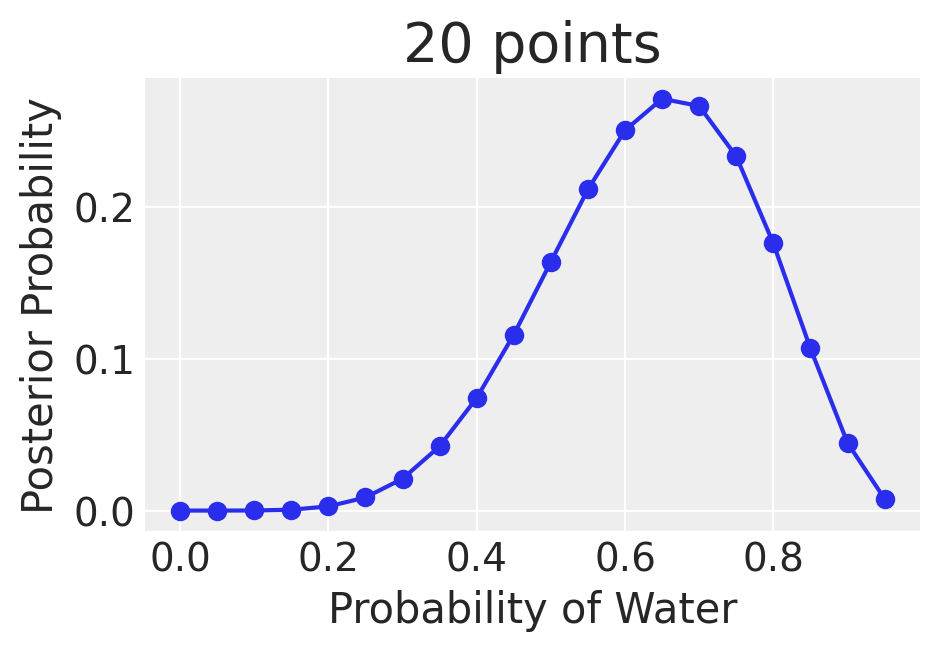

In [7]:
# plot figure
fig = plt.figure(figsize=(5, 3))
plt.plot(p_grid, posterior, 'o-')
plt.xlabel('Probability of Water', fontsize=15)
plt.ylabel('Posterior Probability', fontsize=15)
plt.title('{} points'.format(N), fontsize=20)
plt.show()

### Code 2.5

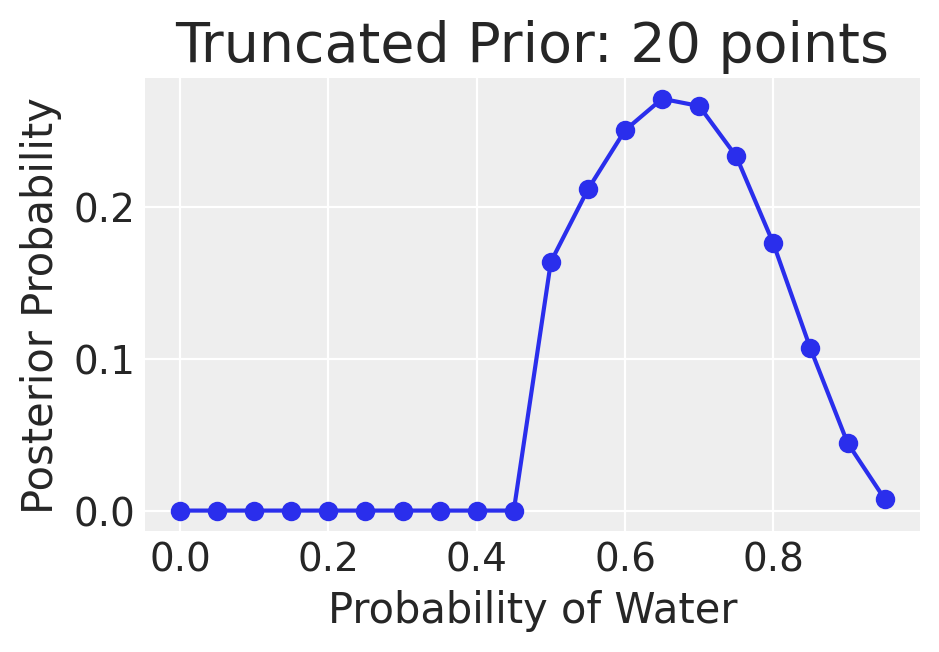

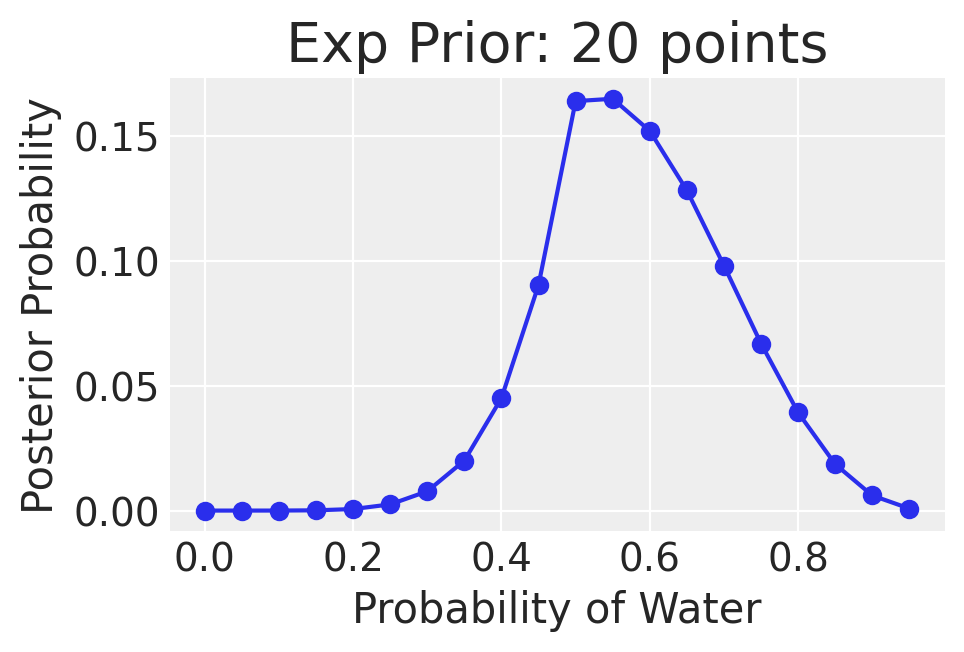

In [8]:
# define truncated prior
prior = np.ones(N)
prior[p_grid<0.5] = 0.
# compute product of likelihood and prior
posterior = likelihood*prior
# standardize the posterior, so it sums to 1
posterior_std = posterior/sum(posterior)
# plot figure
fig = plt.figure(figsize=(5, 3))
plt.plot(p_grid, posterior, 'o-')
plt.xlabel('Probability of Water', fontsize=15)
plt.ylabel('Posterior Probability', fontsize=15)
plt.title('Truncated Prior: {} points'.format(N), fontsize=20)
plt.show()


# define exp prior
prior = np.exp(-5*abs(p_grid-0.5))
# compute product of likelihood and prior
posterior = likelihood*prior
# standardize the posterior, so it sums to 1
posterior_std = posterior/sum(posterior)
# plot figure
fig = plt.figure(figsize=(5, 3))
plt.plot(p_grid, posterior, 'o-')
plt.xlabel('Probability of Water', fontsize=15)
plt.ylabel('Posterior Probability', fontsize=15)
plt.title('Exp Prior: {} points'.format(N), fontsize=20)
plt.show()

##  [Quadratic Approximation](https://www.khanacademy.org/math/multivariable-calculus/applications-of-multivariable-derivatives/quadratic-approximations/a/quadratic-approximation)

1. Non-vector form

\begin{equation}
\begin{aligned}
Q_f(x,y) & = f(x_0+y_0)  \\
         & + f_x(x_0,y_0)(x-x_0) + f_y(x_0,y_0)(y-y_0)  \\
         & + \frac{1}{2}f_{xx}(x_0,y_0)(x-x_0)^2 + f_{xy}(x_0,y_0)(x-x_0)(y-y_0) +\frac{1}{2}f_{yy}(x_0,y_0)(y-y_0)^2 
\end{aligned}
\end{equation}

2. Vector form

\begin{equation}
\begin{aligned}
Q_f(\mathbf{x}) & = f(\mathbf{x_0})  \\
         & + \nabla f(\mathbf{x_0})(\mathbf{x}-\mathbf{x_0})  \\
         & + \frac{1}{2}(\mathbf{x}-\mathbf{x_0})\mathbf{H}_f(\mathbf{x_0})(\mathbf{x}-\mathbf{x_0})
\end{aligned}
\end{equation}

$\nabla f(\mathbf{x_0})$ is the gradient of $f$ evaluated at $\mathbf{x_0}$. 

For example, $\mathbf{x} = \big[\begin{smallmatrix} x \\ y \end{smallmatrix}\big]$, $\nabla f(\mathbf{x_0}) = \big[\begin{smallmatrix} f_x(\mathbf{x_0})\\ f_y(\mathbf{x_0}) \end{smallmatrix}\big]$

$\mathbf{H}_f(\mathbf{x_0})$ is the [Hessian](https://www.khanacademy.org/math/multivariable-calculus/applications-of-multivariable-derivatives/quadratic-approximations/a/the-hessian) matrix of $f$ evaluated at $\mathbf{x_0}$

For example, $\mathbf{x} = \big[\begin{smallmatrix} x \\ y \end{smallmatrix}\big]$, $\nabla \mathbf{H}_f(\mathbf{x_0}) = \big[\begin{smallmatrix} f_{xx}(\mathbf{x_0}) f_{xy}(\mathbf{x_0})\\ f_{yx}(\mathbf{x_0}) f_{yy}(\mathbf{x_0})) \end{smallmatrix}\big]$

In [9]:
total_observations = 9
water_observations = 6
with pm.Model() as normal_aproximation:
    p = pm.Uniform('p', 0, 1)
    w = pm.Binomial('w', n=total_observations, p=p, observed=water_observations)
    mean_q = pm.find_MAP()
    std_q = ((1/pm.find_hessian(mean_q, vars=[p]))**0.5)[0]
mean_q['p'], std_q

logp = -1.8075, ||grad|| = 1.5: 100%|██████████| 7/7 [00:00<00:00, 2553.72it/s]


(array(0.66666667), array([0.15713484]))

In [10]:
norm = stats.norm(mean_q, std_q)
prob = .89
z = stats.norm.ppf([(1-prob)/2, (1+prob)/2])
pi = mean_q['p'] + std_q * z 
pi

array([0.41553484, 0.91779849])

## Analytical Solutions

[Beta Binominal](https://en.wikipedia.org/wiki/Conjugate_prior)

### Code 2.7

In [11]:
water_observations = 6
total_observations = 9

alpha = 1 + water_observations
beta = 1 + total_observations - water_observations
x = np.linspace(0, 1, 100)
posterior_conjugate = stats.beta.pdf(x, a=alpha, b=beta)

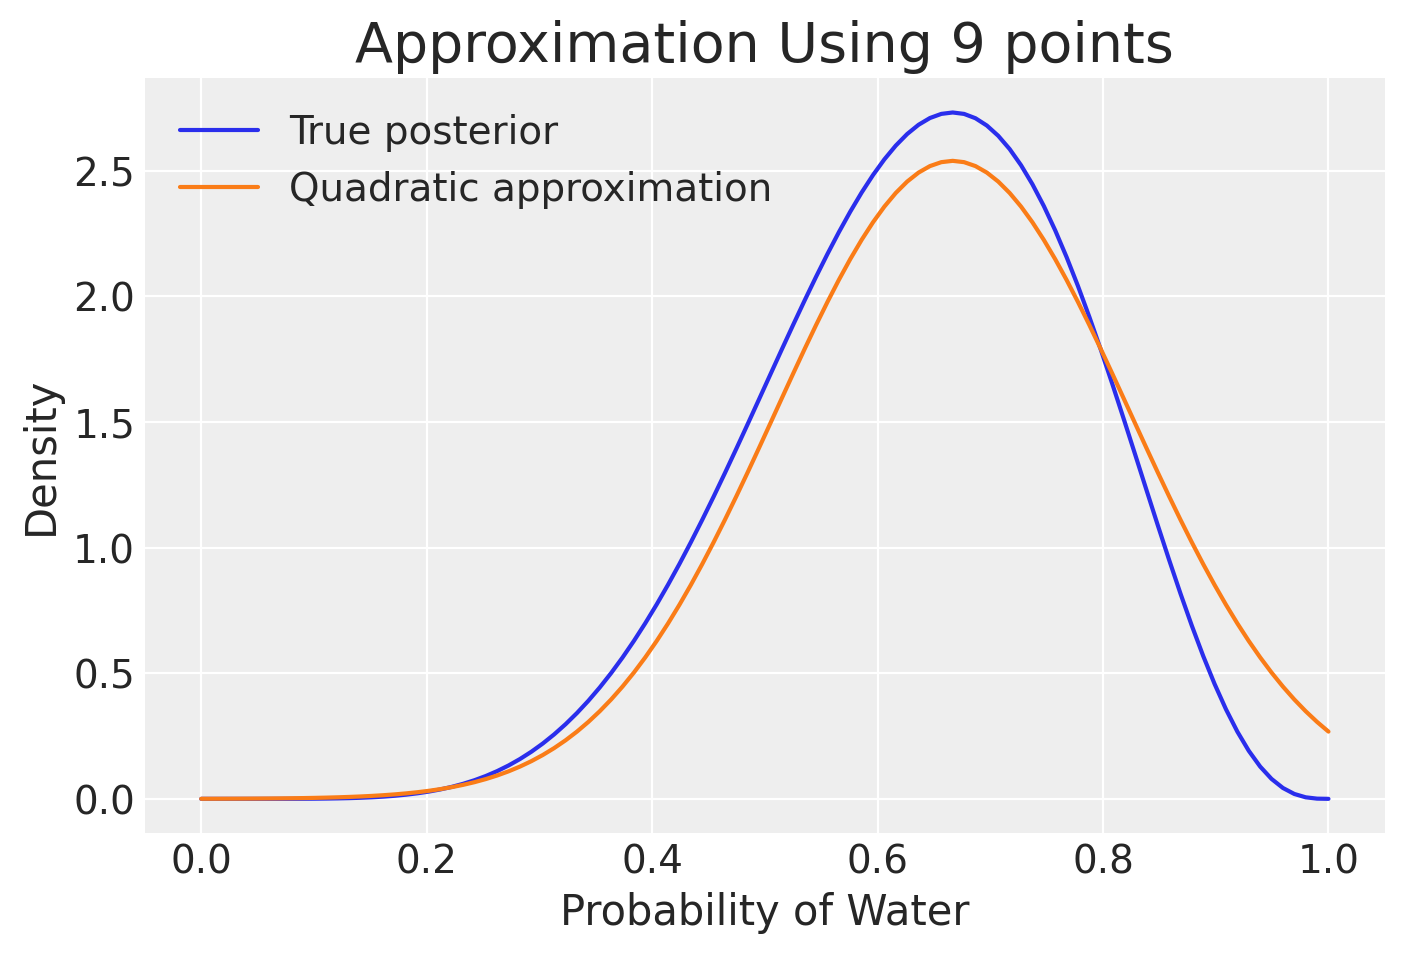

In [12]:
# plot figure compare analytical calculation and 
# quadratic approximation
fig = plt.figure(figsize=(8, 5))
plt.plot(x, posterior_conjugate, label='True posterior')
plt.plot(x, stats.norm.pdf(x, mean_q['p'], std_q),
         label='Quadratic approximation')
plt.xlabel('Probability of Water', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.title('Approximation Using {} points'.format(total_observations), fontsize=20)
plt.legend()
plt.show()

## Markov chain Monte Carlo (MCMC)

[Bayesian Inference Cheatsheet](https://canyon289.github.io/pages/InferenceCheatsheet.html)

[Estimating Probabilities with Bayesian Modeling in Python](https://towardsdatascience.com/estimating-probabilities-with-bayesian-modeling-in-python-7144be007815)


### Code 2.8

In [13]:
# metropolis algorithm
n_samples = 1000
p = np.zeros(n_samples)
p[0] = 0.5
W = 6
L = 3
for i in range(1, n_samples):
    p_new = stats.norm(p[i - 1], 0.1).rvs(1)
    if p_new < 0:
        p_new = -p_new
    if p_new > 1:
        p_new = 2 - p_new
    q0 = stats.binom.pmf(W, n=W + L, p=p[i - 1])
    q1 = stats.binom.pmf(W, n=W + L, p=p_new)
    if stats.uniform.rvs(0, 1) < q1 / q0:
        p[i] = p_new
    else:
        p[i] = p[i - 1]

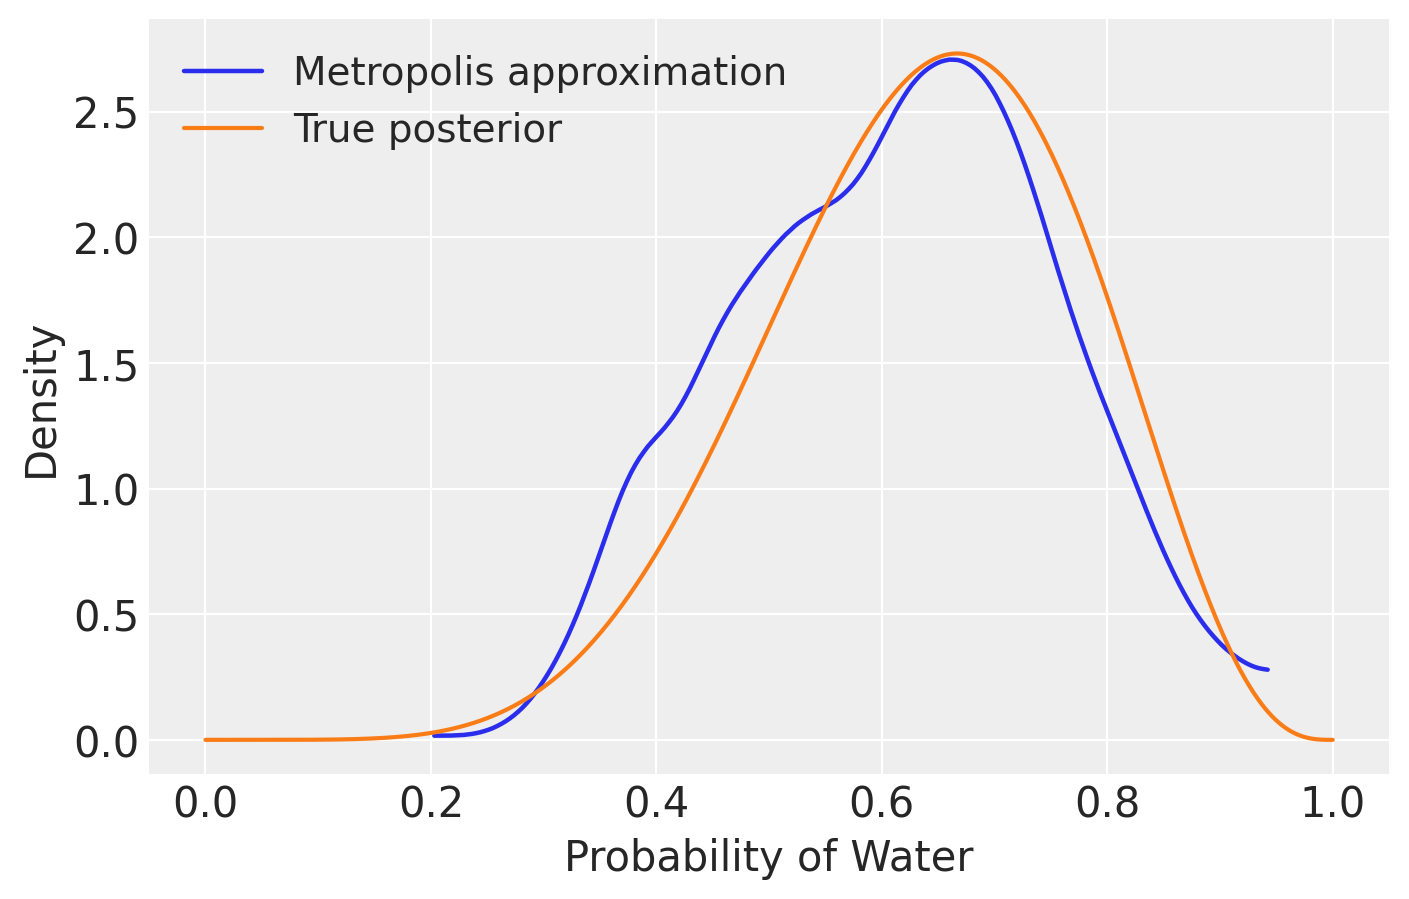

In [14]:
# plot figure
x = np.linspace(0, 1, 1000)
fig = plt.figure(figsize=(8, 5))
az.plot_kde(p, label="Metropolis approximation")
plt.plot(x, stats.beta.pdf(x, a=alpha, b=beta), "C1", label='True posterior')
plt.xlabel('Probability of Water', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.legend()
plt.show()

### Referece

[pymc-devs: Chp02](https://github.com/pymc-devs/resources/blob/master/Rethinking_2/Chp_02.ipynb)